In [4]:
# for this notebook make the path in the same folder (currently is in the project folder)
import os
import sys
import importlib

# Add the path to the val03 folder to sys.path so modules in the same folder can be imported
sys.path.append(os.path.join('notebooks', '103 different weighted'))

In [11]:
from scripts import style
importlib.reload(style)
style.set_style()

In [18]:
# usage_example.py
import importlib
import py103
importlib.reload(py103)

<module 'py103' from 'c:\\Users\\herie\\GitHub\\Proyectos\\En Pausa\\Estimacion de Tendencia\\notebooks\\103 different weighted\\py103.py'>

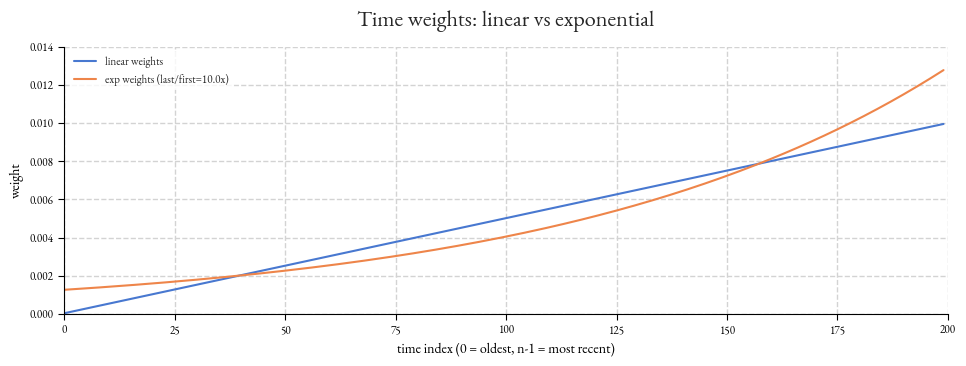


=== Single-transform demo: log_close ===


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== NVDA Elastic Net trend on transform 'log_close' ===
Alpha=0.1000, l1_ratio=0.50
Variance of transformed series: 2.742335e+00
[train    ]  RMSE = 0.380285   RMSE_lin = 0.337416   RMSE_exp = 0.324839
[val      ]  RMSE = 0.395646   RMSE_lin = 0.397221   RMSE_exp = 0.375377
[test     ]  RMSE = 0.466980   RMSE_lin = 0.490752   RMSE_exp = 0.480235
[train_val]  RMSE = 0.384179   RMSE_lin = 0.364121   RMSE_exp = 0.367513

--- Metrics for log_close ---
Variance(log_close): 2.742335e+00
[train    ]  RMSE = 0.380285   RMSE_lin = 0.337416   RMSE_exp = 0.324839
[val      ]  RMSE = 0.395646   RMSE_lin = 0.397221   RMSE_exp = 0.375377
[test     ]  RMSE = 0.466980   RMSE_lin = 0.490752   RMSE_exp = 0.480235
[train_val]  RMSE = 0.384179   RMSE_lin = 0.364121   RMSE_exp = 0.367513

Validation metrics (log_close):
  plain RMSE      : 0.395646
  linear-weighted : 0.397221
  exp-weighted    : 0.375377


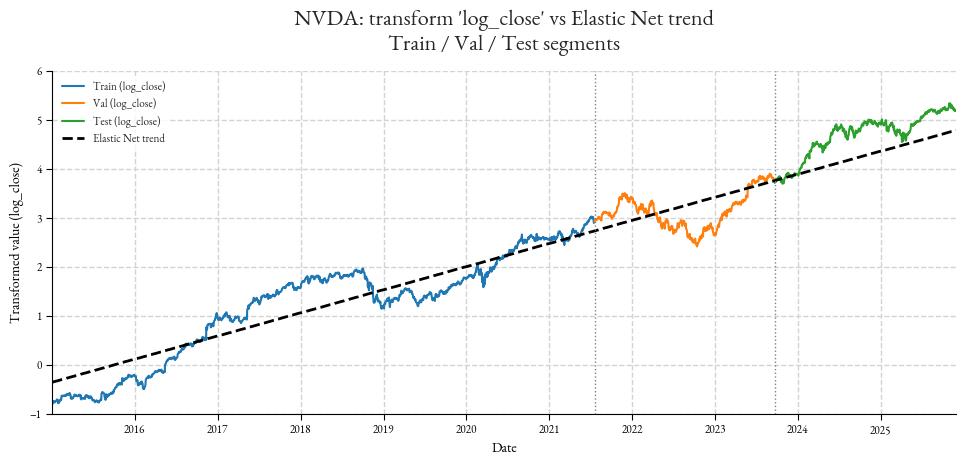

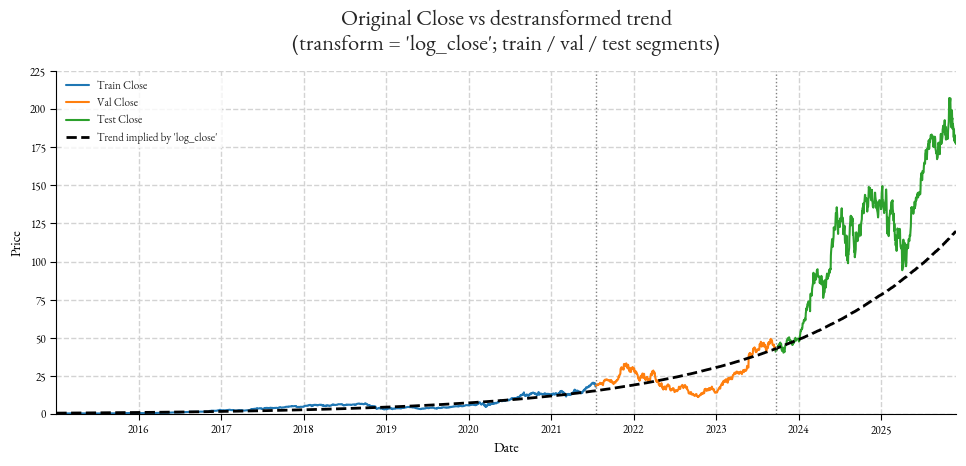


=== All-transforms experiment ===


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== NVDA transform 'close' ===
Variance: 2.324785e+03
[train    ]  RMSE = 2.168647   RMSE_lin = 2.748693   RMSE_exp = 2.884650
[val      ]  RMSE = 14.184988   RMSE_lin = 16.706242   RMSE_exp = 17.899510
[test     ]  RMSE = 108.591443   RMSE_lin = 126.958000   RMSE_exp = 129.033450
[train_val]  RMSE = 7.333891   RMSE_lin = 9.852094   RMSE_exp = 10.657070

=== NVDA transform 'log_close' ===
Variance: 2.742335e+00
[train    ]  RMSE = 0.380285   RMSE_lin = 0.337416   RMSE_exp = 0.324839
[val      ]  RMSE = 0.395646   RMSE_lin = 0.397221   RMSE_exp = 0.375377
[test     ]  RMSE = 0.466980   RMSE_lin = 0.490752   RMSE_exp = 0.480235
[train_val]  RMSE = 0.384179   RMSE_lin = 0.364121   RMSE_exp = 0.367513

=== NVDA transform 'sqrt_close' ===
Variance: 1.277834e+01
[train    ]  RMSE = 0.357259   RMSE_lin = 0.422682   RMSE_exp = 0.430728
[val      ]  RMSE = 1.268103   RMSE_lin = 1.391148   RMSE_exp = 1.486884
[test     ]  RMSE = 6.096726   RMSE_lin = 6.895719   RMSE_exp = 6.943974
[train_val]  

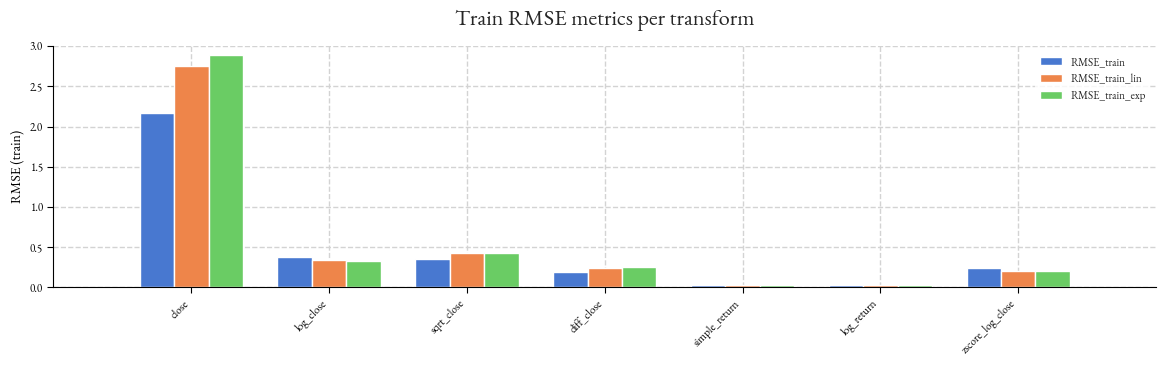

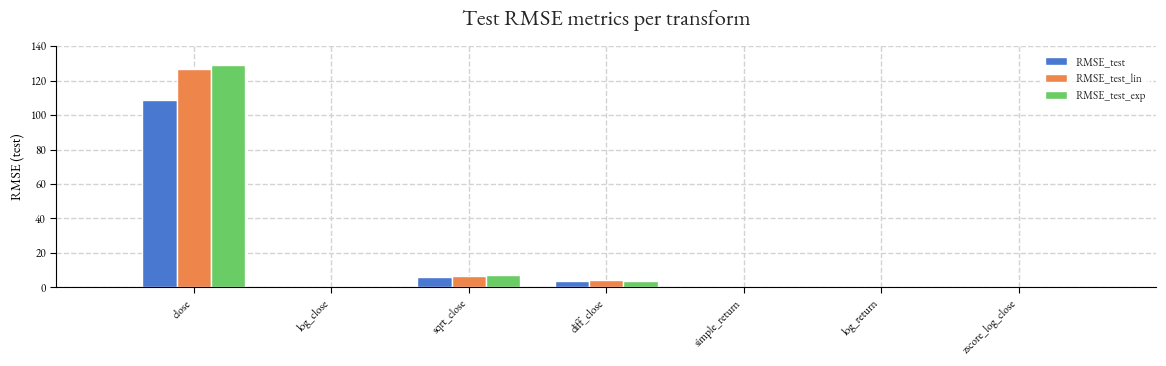


=== Multi-row subplot figure (transforms + destransforms) ===


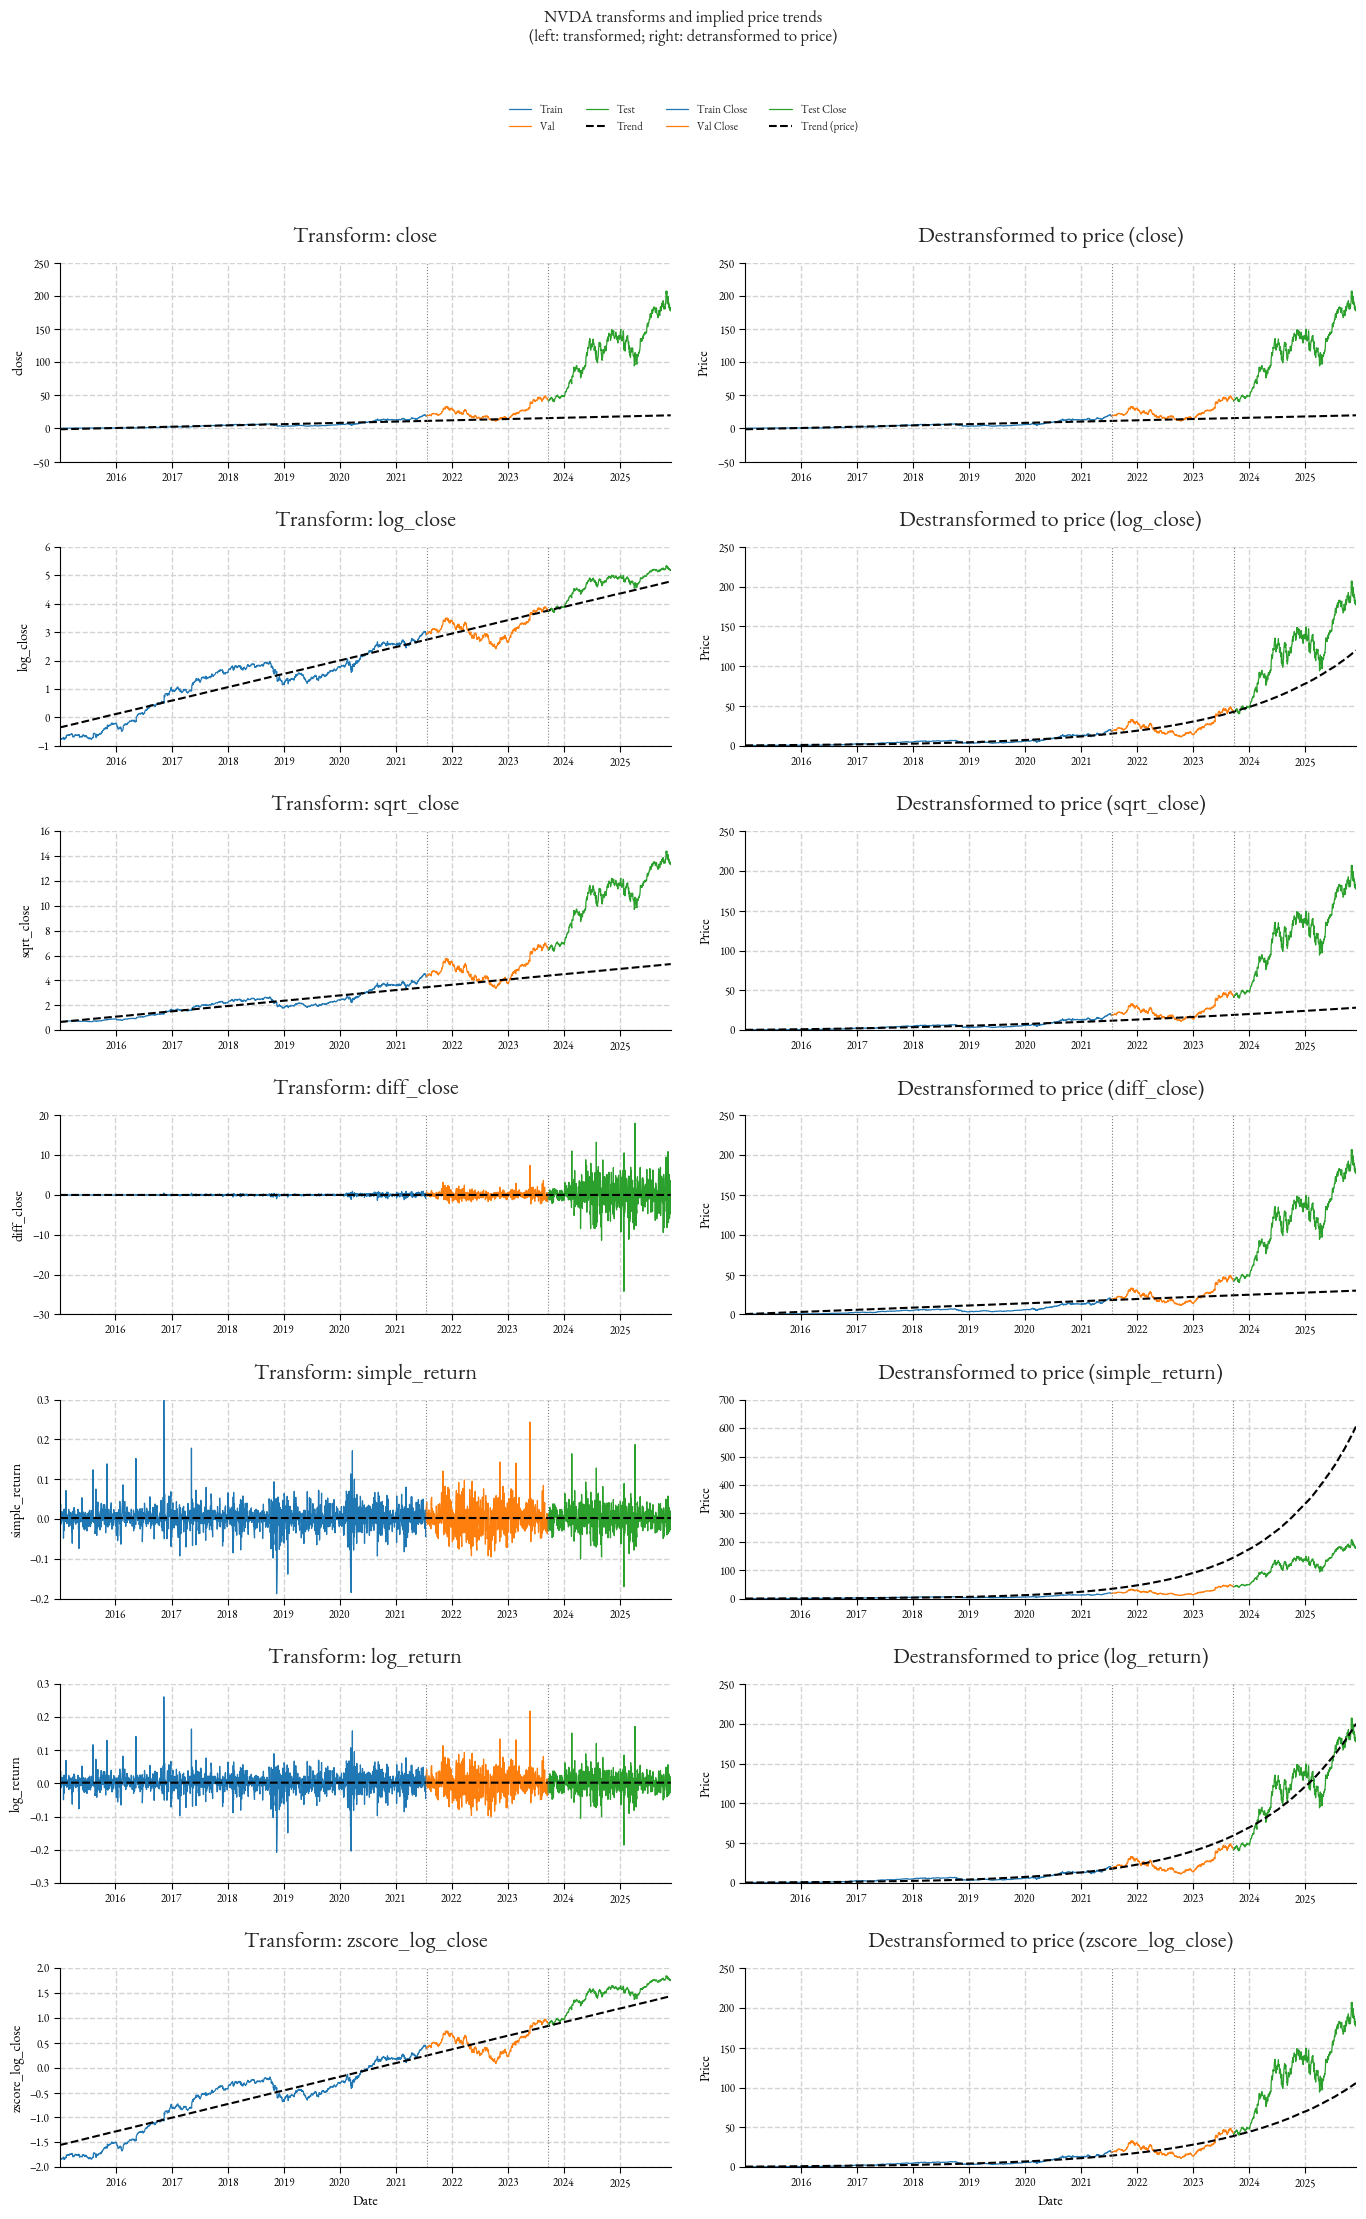

In [20]:
# ==== demo_103_all.py =====================================================
# Complete demonstration of py103:
#  - Shows weight profiles (linear vs exponential).
#  - Runs single-transform demo for "log_close" with plots.
#  - Runs all transforms, prints metrics, plots bar charts.
#  - Builds big subplot grid: transforms + destransformed trends.
# ==========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import py103  # your module with all the functions
importlib.reload(py103)

from py103 import (
    run_transform_experiment,
    run_all_transforms_experiment,
    subplot_all_transforms_and_destransforms,
    plot_transform_trend,
    plot_destransformed_price_trend,
)


# ============================================================
# 0) Helper: visualize weight schemes (linear vs exponential)
# ============================================================

def demo_plot_weight_profiles(n: int = 200, ratio_last_first: float = 10.0) -> None:
    """
    Plot linear and exponential time weights on the same horizon [0,...,n-1].

    Linear:
        w_i ∝ (i+1)

    Exponential:
        w_i ∝ gamma^i, with gamma chosen so that
        w_last / w_first = ratio_last_first.
    """
    idx = np.arange(n, dtype=float)

    # Linear weights
    w_lin = (idx + 1.0) / np.sum(idx + 1.0)

    # Exponential weights
    r = max(float(ratio_last_first), 1.0 + 1e-9)
    gamma = r ** (1.0 / float(n - 1))
    w_exp_unnorm = gamma ** idx
    w_exp = w_exp_unnorm / np.sum(w_exp_unnorm)

    plt.figure(figsize=(10, 4))
    plt.plot(idx, w_lin, label="linear weights", linewidth=1.5)
    plt.plot(idx, w_exp, label=f"exp weights (last/first={ratio_last_first:.1f}x)",
             linewidth=1.5)
    plt.xlabel("time index (0 = oldest, n-1 = most recent)")
    plt.ylabel("weight")
    plt.title("Time weights: linear vs exponential")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 1) Single-transform demo: log prices ("log_close")
# ============================================================

def demo_single_transform_log_close() -> None:
    """
    Show:
      - metrics for log_close (RMSE, RMSE_lin, RMSE_exp)
      - transformed-space plot
      - price-space (destransformed) plot
    """
    print("\n=== Single-transform demo: log_close ===")

    log_result, log_model, df_nvda = run_transform_experiment(
        transform_name="log_close",
        ticker="NVDA",
        start="2015-01-01",
        end=None,
        alpha=0.1,
        l1_ratio=0.5,
        random_state=0,
        train_frac=0.6,
        val_frac=0.2,
    )

    print("\n--- Metrics for log_close ---")
    print(f"Variance(log_close): {log_result['variance']:.6e}")
    for split_name, m in log_result["metrics"].items():
        print(
            f"[{split_name:9s}]  "
            f"RMSE = {m['rmse']:.6f}   "
            f"RMSE_lin = {m['rmse_w_linear']:.6f}   "
            f"RMSE_exp = {m['rmse_w_exp']:.6f}"
        )

    # Example: access validation metrics explicitly
    val_metrics = log_result["metrics"]["val"]
    print("\nValidation metrics (log_close):")
    print(f"  plain RMSE      : {val_metrics['rmse']:.6f}")
    print(f"  linear-weighted : {val_metrics['rmse_w_linear']:.6f}")
    print(f"  exp-weighted    : {val_metrics['rmse_w_exp']:.6f}")

    # (1) Plot log_close transform + trend (transformed space)
    plot_transform_trend(
        df_nvda,
        log_model,
        transform_name="log_close",
        train_frac=0.6,
        val_frac=0.2,
    )

    # (2) Plot destransformed trend (back to price space)
    plot_destransformed_price_trend(
        df_nvda,
        log_model,
        transform_name="log_close",
        train_frac=0.6,
        val_frac=0.2,
    )


# ============================================================
# 2) All transforms: metrics summary + bar charts
# ============================================================

def demo_all_transforms_summary_and_bars() -> tuple[dict, dict, pd.DataFrame]:
    """
    Run all transforms and:
      - print full metrics summary
      - produce bar charts for train/test RMSE metrics across transforms

    Returns:
      all_results, all_models, df_all
    """
    print("\n=== All-transforms experiment ===")

    # transform_names=None now handled inside py103.run_all_transforms_experiment
    all_results, all_models, df_all = run_all_transforms_experiment(
        transform_names=None,
        ticker="NVDA",
        start="2015-01-01",
        end=None,
        alpha=0.1,
        l1_ratio=0.5,
        random_state=0,
        train_frac=0.6,
        val_frac=0.2,
    )

    print("\n=== SUMMARY OVER ALL TRANSFORMS (train & test) ===")
    for name, res in all_results.items():
        var_ = res["variance"]
        m_train = res["metrics"]["train"]
        m_test = res["metrics"]["test"]

        print(
            f"{name:15s} | Var = {var_: .6e} | "
            f"RMSE_train = {m_train['rmse']:.6f} "
            f"(lin={m_train['rmse_w_linear']:.6f}, exp={m_train['rmse_w_exp']:.6f}) | "
            f"RMSE_test  = {m_test['rmse']:.6f} "
            f"(lin={m_test['rmse_w_linear']:.6f}, exp={m_test['rmse_w_exp']:.6f})"
        )

    # ---------- Build bar charts ----------

    transform_names = list(all_results.keys())
    n = len(transform_names)

    # Collect metrics into arrays
    rmse_train = np.zeros(n)
    rmse_train_lin = np.zeros(n)
    rmse_train_exp = np.zeros(n)

    rmse_test = np.zeros(n)
    rmse_test_lin = np.zeros(n)
    rmse_test_exp = np.zeros(n)

    for i, name in enumerate(transform_names):
        m_train = all_results[name]["metrics"]["train"]
        m_test = all_results[name]["metrics"]["test"]

        rmse_train[i] = m_train["rmse"]
        rmse_train_lin[i] = m_train["rmse_w_linear"]
        rmse_train_exp[i] = m_train["rmse_w_exp"]

        rmse_test[i] = m_test["rmse"]
        rmse_test_lin[i] = m_test["rmse_w_linear"]
        rmse_test_exp[i] = m_test["rmse_w_exp"]

    x = np.arange(n)
    width = 0.25

    # Train RMSE bar chart
    plt.figure(figsize=(12, 4))
    plt.bar(x - width, rmse_train, width=width, label="RMSE_train")
    plt.bar(x, rmse_train_lin, width=width, label="RMSE_train_lin")
    plt.bar(x + width, rmse_train_exp, width=width, label="RMSE_train_exp")
    plt.xticks(x, transform_names, rotation=45, ha="right")
    plt.ylabel("RMSE (train)")
    plt.title("Train RMSE metrics per transform")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Test RMSE bar chart
    plt.figure(figsize=(12, 4))
    plt.bar(x - width, rmse_test, width=width, label="RMSE_test")
    plt.bar(x, rmse_test_lin, width=width, label="RMSE_test_lin")
    plt.bar(x + width, rmse_test_exp, width=width, label="RMSE_test_exp")
    plt.xticks(x, transform_names, rotation=45, ha="right")
    plt.ylabel("RMSE (test)")
    plt.title("Test RMSE metrics per transform")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results, all_models, df_all


# ============================================================
# 3) Big subplot grid: all transforms + all destransforms
# ============================================================

def demo_subplots_all_transforms_and_destransforms(
    df_all: pd.DataFrame,
    all_models: dict,
    transform_subset: list[str] | None = None,
) -> None:
    """
    Use the helper from py103 to create the big figure:

      rows = transforms
      col 0 = transformed series + trend
      col 1 = original prices + destransformed trend
    """
    print("\n=== Multi-row subplot figure (transforms + destransforms) ===")

    subplot_all_transforms_and_destransforms(
        df=df_all,
        models=all_models,
        transform_names=transform_subset,  # None => all
        train_frac=0.6,
        val_frac=0.2,
    )


# ============================================================
# 4) Run everything when this file is executed as script
# ============================================================

if __name__ == "__main__":
    # (A) Weight profiles: linear vs exponential
    demo_plot_weight_profiles(n=200, ratio_last_first=10.0)

    # (B) Single-transform demonstration for log_close
    demo_single_transform_log_close()

    # (C) All transforms: metrics + bar charts
    all_results, all_models, df_all = demo_all_transforms_summary_and_bars()

    # (D) Big subplot grid (all transforms)
    demo_subplots_all_transforms_and_destransforms(
        df_all=df_all,
        all_models=all_models,
        transform_subset=None,   # or e.g. ['close', 'log_close', 'log_return']
    )


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== Weighted-training comparison for transform 'log_close' ===
Alpha=0.1000, l1_ratio=0.50, ratio_last_first=10.0
[mode=plain ]  RMSE_val = 0.395646   RMSE_val_lin = 0.397221   RMSE_val_exp = 0.375377
[mode=linear]  RMSE_val = 0.382586   RMSE_val_lin = 0.350279   RMSE_val_exp = 0.359162
[mode=exp   ]  RMSE_val = 0.366483   RMSE_val_lin = 0.343919   RMSE_val_exp = 0.336861

=== VALIDATION METRICS BY TRAINING MODE (log_close) ===
mode=plain  | RMSE_val = 0.395646 | RMSE_val_lin = 0.397221 | RMSE_val_exp = 0.375377
mode=linear | RMSE_val = 0.382586 | RMSE_val_lin = 0.350279 | RMSE_val_exp = 0.359162
mode=exp    | RMSE_val = 0.366483 | RMSE_val_lin = 0.343919 | RMSE_val_exp = 0.336861


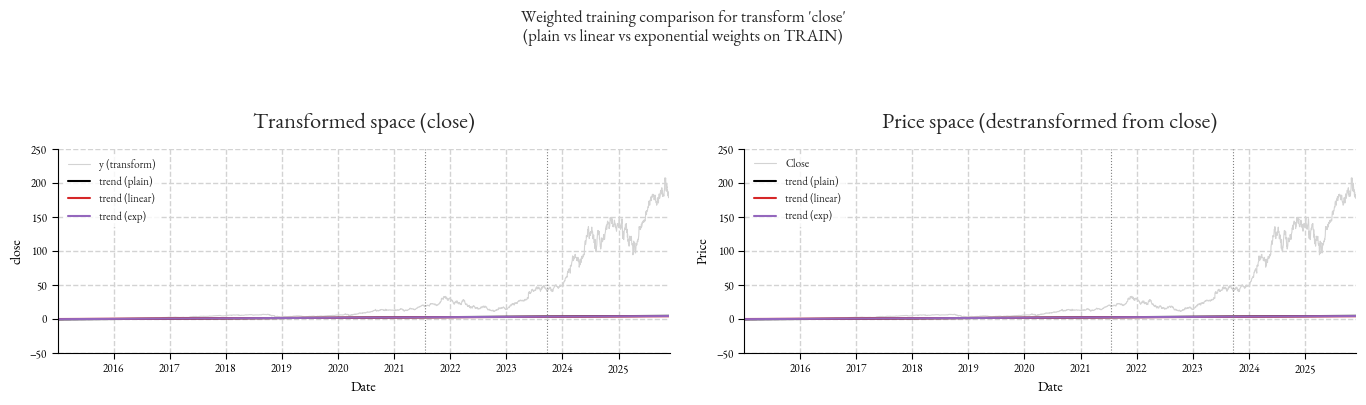

In [23]:
# example_weighted_training_comparison_log_close.py

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import py103
importlib.reload(py103)

from py103 import (
    run_weighted_training_comparison_single_transform,
    plot_weighted_training_comparison,
)

# ============================================================
# 1) Train with three weight schemes on log_close
# ============================================================

results_by_mode, models_by_mode, df_nvda = run_weighted_training_comparison_single_transform(
    transform_name="log_close",
    ticker="NVDA",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    ratio_last_first=10.0,   # exp weights: last ≈ 10x first
)

print("\n=== VALIDATION METRICS BY TRAINING MODE (log_close) ===")
for mode, metrics in results_by_mode.items():
    m_val = metrics["val"]
    print(
        f"mode={mode:6s} | "
        f"RMSE_val = {m_val['rmse']:.6f} | "
        f"RMSE_val_lin = {m_val['rmse_w_linear']:.6f} | "
        f"RMSE_val_exp = {m_val['rmse_w_exp']:.6f}"
    )

# ============================================================
# 2) Plot the three fitted lines together
#    - left: in transformed space (log_close)
#    - right: in price space after destransformation
# ============================================================

plot_weighted_training_comparison(
    df=df_nvda,
    models_by_mode=models_by_mode,
    transform_name="close",
    train_frac=0.6,
    val_frac=0.2,
)
